# Centroid-UNet for Coconut Tree Mapping in Tongo

<br><br>

In [1]:
'''importing libraries'''

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv1D, Concatenate, Conv2DTranspose, GaussianNoise, Lambda, Dropout, Flatten, Dense, Reshape, TimeDistributed, Permute, Softmax, Multiply, BatchNormalization, UpSampling2D
from keras import backend as K
import tensorflow as tf
from keras.models import model_from_json

import glob
from random import shuffle, randint
import numpy as np
from matplotlib import pyplot as plt
import imageio
import json

import DataUtils
import Model

Using TensorFlow backend.


### 1) Reading Data

In [2]:
'''setting image size'''

## in_h and in_w must be should be divisible by 2^4, making them suitable for 4 max pooling operations

in_h = 1280 # model input height
in_w = 1280 # model input width

In [3]:
'''reading training data'''

imList = glob.glob("./data/TongoCoconutTree/train/*.tiff")

x_train = np.zeros((len(imList), in_h, in_w, 3)).astype('float32')
y_train = np.zeros((len(imList), in_h, in_w, 1)).astype('float32')

for i1 in range(len(imList)):
    x_train[i1,:,:,:] = imageio.imread(imList[i1])
    
    with open(imList[i1].replace('train', 'train_labels').replace('tiff', 'json')) as f:
        ctr_list = json.load(f)['centroids']
        ctr_img = DataUtils.centroids2Images(ctr_list, im_num_row=in_h, im_num_col=in_w, g_radius=40)
        
        y_train[i1,:,:,0] = ctr_img
        
print(x_train.shape)
print(y_train.shape)

(159, 1280, 1280, 3)
(159, 1280, 1280, 1)


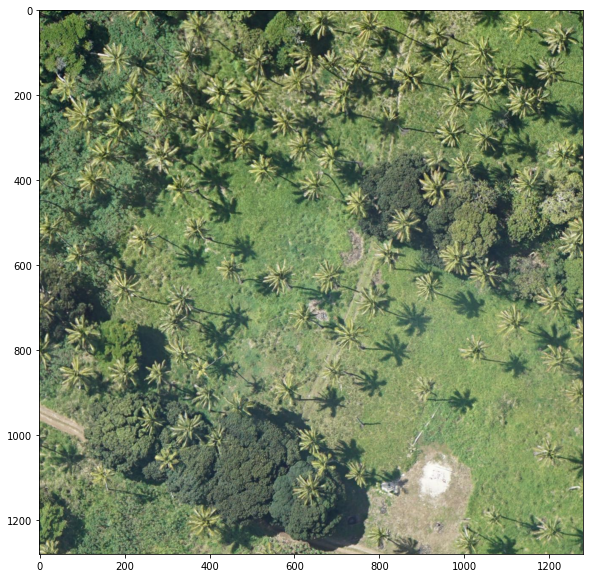

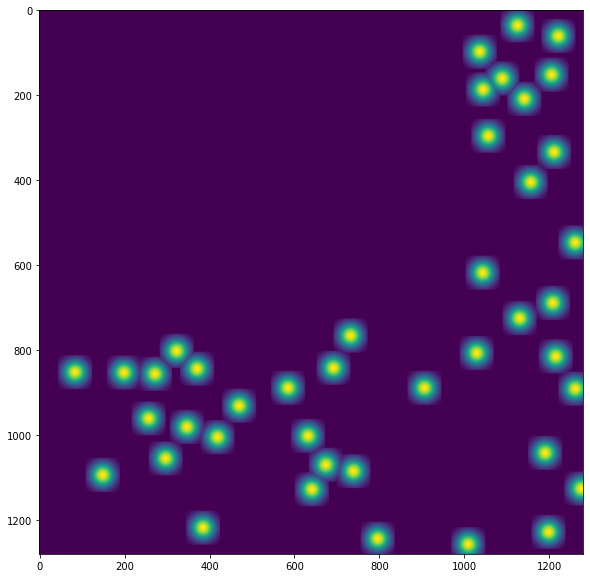

In [4]:
'''visualizing random input/output training images'''

rdm_idx = randint(0, len(imList))

plt.figure(figsize=(10, 10))
plt.imshow(x_train[rdm_idx,:,:,:].astype('uint8'))
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(y_train[rdm_idx,:,:,0])
plt.show()

In [5]:
'''reading val data'''

imList = glob.glob("./data/TongoCoconutTree/val/*.tiff")

x_val = np.zeros((len(imList), in_h, in_w, 3)).astype('float32')
y_val = np.zeros((len(imList), in_h, in_w, 1)).astype('float32')

for i1 in range(len(imList)):
    x_val[i1,:,:,:] = imageio.imread(imList[i1])
    
    with open(imList[i1].replace('val', 'val_labels').replace('tiff', 'json')) as f:
        ctr_list = json.load(f)['centroids']
        ctr_img = DataUtils.centroids2Images(ctr_list, im_num_row=in_h, im_num_col=in_w, g_radius=40)
        y_val[i1,:,:,0] = ctr_img
        
print(x_val.shape)
print(y_val.shape)

(30, 1280, 1280, 3)
(30, 1280, 1280, 1)


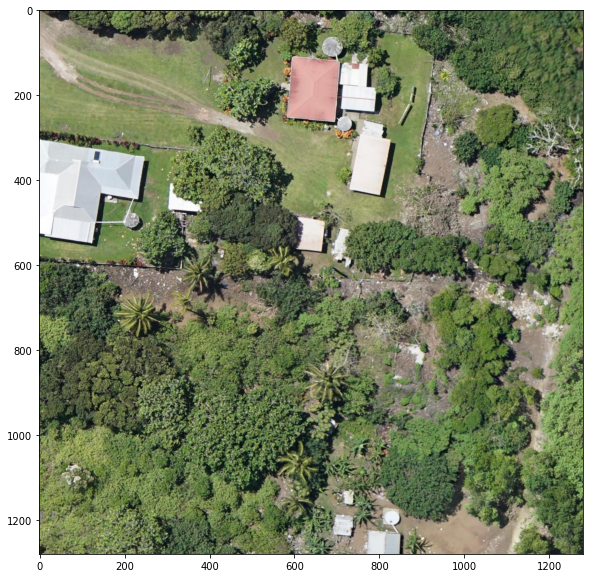

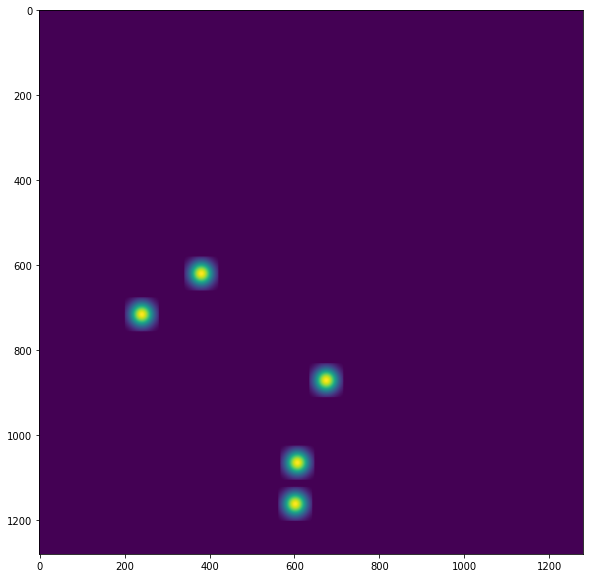

In [6]:
'''visualizing random input/output val images'''

rdm_idx = randint(0, len(imList))

plt.figure(figsize=(10, 10))
plt.imshow(x_val[rdm_idx,:,:,:].astype('uint8'))
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(y_val[rdm_idx,:,:,0])
plt.show()

### 2) Model Development and Training

In [8]:
'''building U-Net model'''

model = Model.getModel(input_shape=(in_h,in_w,3))

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1280, 1280, 3 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 1280, 1280, 3 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 1280, 1280, 3 128         conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 1280, 1280, 3 9248        batch_normalization_21[0][0]     
____________________________________________________________________________________________

In [9]:
'''fitting the model'''

batch_size = 1
epochs = 50

fit_h = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=1, validation_data=(x_val, y_val))


Train on 159 samples, validate on 30 samples
Epoch 1/50
159/159 [==============================] - 83s 522ms/step - loss: 0.0753 - val_loss: 0.0272
Epoch 2/50
159/159 [==============================] - 78s 489ms/step - loss: 0.0253 - val_loss: 0.0192
Epoch 3/50
159/159 [==============================] - 78s 489ms/step - loss: 0.0177 - val_loss: 0.2393
Epoch 4/50
159/159 [==============================] - 78s 489ms/step - loss: 0.0143 - val_loss: 0.0126
Epoch 5/50
159/159 [==============================] - 78s 488ms/step - loss: 0.0119 - val_loss: 0.0136
Epoch 6/50
159/159 [==============================] - 78s 489ms/step - loss: 0.0113 - val_loss: 0.0120
Epoch 7/50
159/159 [==============================] - 78s 489ms/step - loss: 0.0129 - val_loss: 0.0134
Epoch 8/50
159/159 [==============================] - 78s 489ms/step - loss: 0.0111 - val_loss: 0.0144
Epoch 9/50
159/159 [==============================] - 78s 490ms/step - loss: 0.0109 - val_loss: 0.0132
Epoch 10/50
159/159 [======

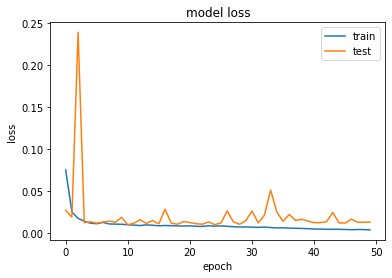

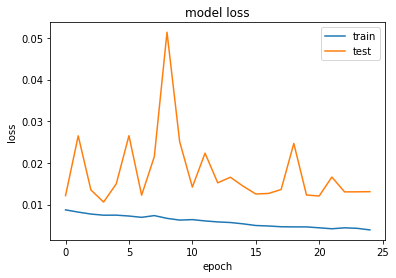

In [10]:
'''plotting loss curves'''

plt.plot(fit_h.history['loss'])
plt.plot(fit_h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(fit_h.history['loss'][25:])
plt.plot(fit_h.history['val_loss'][25:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [11]:
'''saving the model'''

model_json = model.to_json()
with open("./models/TongoCoconutTree.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("./models/TongoCoconutTree.h5")

np.savetxt('./models/TongoCoconutTree_loss.txt', fit_h.history['loss'], fmt='%.8f')
np.savetxt('./models/TongoCoconutTree_loss_val.txt', fit_h.history['val_loss'], fmt='%.8f')

### 3) Inference

In [3]:
'''reading test data'''

imList = glob.glob("./data/TongoCoconutTree/test/*.tiff")

x_test = np.zeros((len(imList), in_h, in_w, 3)).astype('float32')
y_test = np.zeros((len(imList), in_h, in_w, 1)).astype('float32')

for i1 in range(len(imList)):
    x_test[i1,:,:,:] = imageio.imread(imList[i1])
    
    with open(imList[i1].replace('test', 'test_labels').replace('tiff', 'json')) as f:
        ctr_list = json.load(f)['centroids']
        ctr_img = DataUtils.centroids2Images(ctr_list, im_num_row=in_h, im_num_col=in_w, g_radius=40)
        y_test[i1,:,:,0] = ctr_img
        
print(x_test.shape)
print(y_test.shape)

(58, 1280, 1280, 3)
(58, 1280, 1280, 1)


In [5]:
'''loading model'''

json_file = open('./models/TongoCoconutTree.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_infr = model_from_json(loaded_model_json)
model_infr.load_weights("./models/TongoCoconutTree.h5")

In [6]:
'''inference'''

p_test = model_infr.predict(x_test, batch_size = 1)
print(p_test.shape)


(58, 1280, 1280, 1)


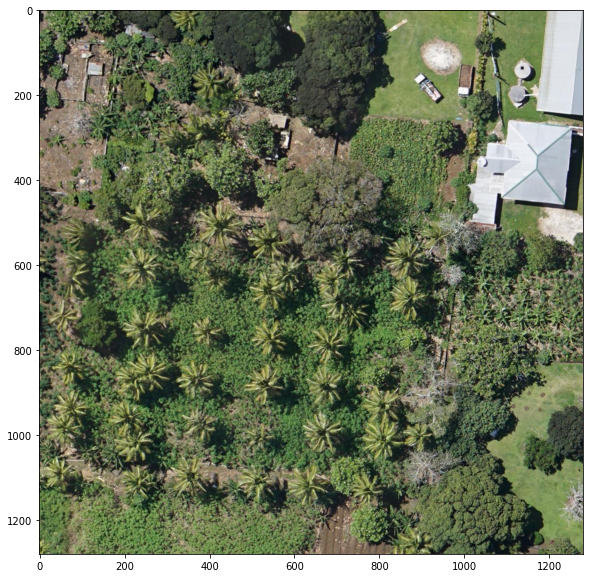

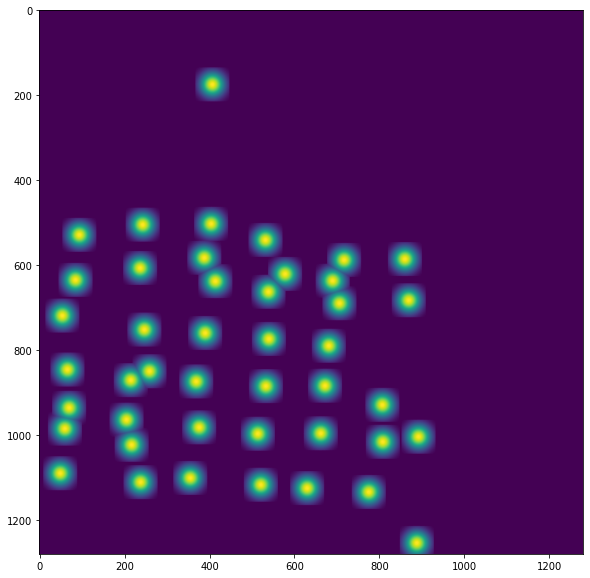

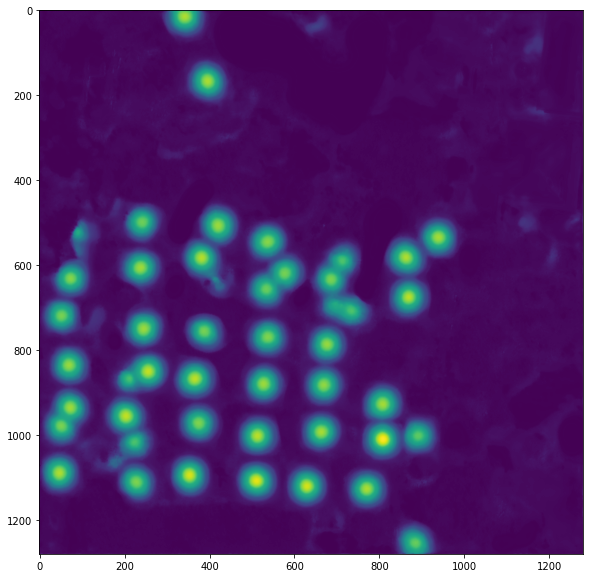

In [17]:
'''visualizing random input/output/prediction images'''

rdm_idx = randint(0, len(imList))

plt.figure(figsize=(10, 10))
plt.imshow(x_test[rdm_idx,:,:,:].astype('uint8'))
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(y_test[rdm_idx,:,:,0])
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(p_test[rdm_idx,:,:,0])
plt.show()

In [18]:
plt.imsave( 'sample3_rgb.png', x_test[rdm_idx,:,:,:].astype('uint8') )
plt.imsave( 'sample3_gr.png', y_test[rdm_idx,:,:,0] )
plt.imsave( 'sample3_pred.png', p_test[rdm_idx,:,:,0] )